This notebook loads data including QQQ and has two modes to run. Generated data with ranks with different parameters so in the end it has multilvel index depending on the parameters  - lookback period X, lookback period Y and so on. then generated strategy based on different stocks (strategy is simple , just buy best x stocks) and final output is simulation and heatmap.

As for the second mode, it includes QQQ, strategy is changed to take consideration of QQQ. QQQ ranks are calcualted as other ranks, and if during the simulation, QQQ ranks is zero than either we don;t do anything until it gets better (positive again) or sell everythig, re buy other once it's get better.


Data is bi-weekly

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import vectorbt as vbt
from numba import njit
import plotly as plt
from vectorbt.portfolio import nb
import openpyxl
import quantstats as qs
from pandas_datareader import data as pdr
import yfinance as yfin
import glob
from csv import reader
import time
import requests
from bs4 import BeautifulSoup

vbt.settings["caching"]["enabled"] = False
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.options.display.max_seq_items = 2000

In [3]:
#!pip install yfinance==0.2.58

In [4]:
dataset = "QQQ" #should be either "QQQ" or "SNP"
single_params = {"lookback_period":250, "roc_period": 250, "stocks":2}
# Vanilla stays with 1 stock, Correl gets 2 Stock, 250/250  is the best.
multi_params = {"min_lookback_period": 100, "max_lookback_period":300,
                "min_roc_period":100, "max_roc_period": 300,
               "step": 50, "min_stocks":5, "max_stocs": 5}

simulation_type = "single" #should be either "single" or "multi"
wild = False
update = True

In [5]:
data = None
qqq_rank = None

In [6]:
def get_nasdaq_100_symbols():
    url = "https://en.wikipedia.org/wiki/Nasdaq-100"
    
    # 1. Add a User-Agent header to mimic a browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }
    
    try:
        # 2. Pass the headers in the request
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # 3. Find the table with the 'Ticker' column
        tables = soup.find_all('table', {'class': 'wikitable'})
        
        target_table = None
        for table in tables:
            headers_text = [th.text.strip() for th in table.find_all('th')]
            if "Ticker" in headers_text:
                target_table = table
                break
        
        if not target_table:
            print("Could not find the components table.")
            return []

        symbols = []
        for row in target_table.find_all('tr')[1:]:
            cols = row.find_all(['td', 'th'])
            if cols:
                ticker = cols[0].text.strip()
                symbols.append(ticker)
        
        return symbols

    except requests.exceptions.RequestException as e:
        print(f"Error fetching page: {e}")
        return []

nasdaq_symbols = get_nasdaq_100_symbols()
    
print(f"Found {len(nasdaq_symbols)} symbols:")
print(nasdaq_symbols)

Found 101 symbols:
['ADBE', 'AMD', 'ABNB', 'ALNY', 'GOOGL', 'GOOG', 'AMZN', 'AEP', 'AMGN', 'ADI', 'AAPL', 'AMAT', 'APP', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'AXON', 'BKR', 'BKNG', 'AVGO', 'CDNS', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DASH', 'EA', 'EXC', 'FAST', 'FER', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'INSM', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LIN', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MSTR', 'MDLZ', 'MPWR', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PLTR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'STX', 'SHOP', 'SBUX', 'SNPS', 'TMUS', 'TTWO', 'TSLA', 'TXN', 'TRI', 'VRSK', 'VRTX', 'WBD', 'WDC', 'WDAY', 'XEL', 'ZS']


In [8]:
if update == True:
    # Data update
    #outdated...
    #yfin.pdr_override()
    # open file in read mode
    from1 = "2023-12-02"
    to = "2026-01-06"
    #Delete all
    fileList = glob.glob(r'/home/jj/Stocks/Data/QQQ/*.csv')
    
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

    if wild == True:
        paf = r'/home/jj/Stocks/Data/WILD.csv'
    else:
        paf = r'/home/jj/Stocks/Data/NASDAQ.csv'
    
    #Download all
    # pass the file object to reader() to get the reader object
    csv_reader = nasdaq_symbols
    # Iterate over each row in the csv using reader object
    downloads = {}
    t = 1
    for row in csv_reader:
        # row variable is a list that represents a row in csv
        string = ''
        path = r'/home/jj/Stocks/Data/QQQ/'
        print(row)
        
        try:
            hist = yfin.download(string.join(row), from1, to)
            #time. sleep(3)
            #hist = web.DataReader(string.join(row), 'yahoo', from1, to)
        except:
            print("Not available with Yahoo: ",row)

        downloads[t] = len(hist)
        if downloads[t] == downloads[1]:
            hist.to_csv(path + string.join(row) + '.csv')
        else:
          print("Stock not the full time on exchange", str(row))
        t += 1

    #Download Benchmark
    
    row = "QQQ"
    string = ''
    path = '/home/jj/Stocks/Data/QQQ/'
    hist = yfin.download(string.join(row), from1, to)
    hist.to_csv(path + string.join(row) + '.csv')
    

ADBE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


AMD
ABNB


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ALNY
GOOGL


[*********************100%***********************]  1 of 1 completed


GOOG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


AMZN
AEP


[*********************100%***********************]  1 of 1 completed


AMGN


[*********************100%***********************]  1 of 1 completed


ADI


[*********************100%***********************]  1 of 1 completed


AAPL


[*********************100%***********************]  1 of 1 completed


AMAT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


APP
ARM


[*********************100%***********************]  1 of 1 completed


ASML


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


AZN
TEAM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ADSK
ADP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


AXON
BKR


[*********************100%***********************]  1 of 1 completed


BKNG


[*********************100%***********************]  1 of 1 completed


AVGO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


CDNS
CHTR


[*********************100%***********************]  1 of 1 completed


CTAS


[*********************100%***********************]  1 of 1 completed


CSCO


[*********************100%***********************]  1 of 1 completed


CCEP


[*********************100%***********************]  1 of 1 completed


CTSH


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


CMCSA
CEG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


CPRT
CSGP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


COST
CRWD


[*********************100%***********************]  1 of 1 completed


CSX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


DDOG
DXCM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


FANG
DASH


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


EA
EXC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


FAST
FER


[*********************100%***********************]  1 of 1 completed


FTNT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


GEHC
GILD


[*********************100%***********************]  1 of 1 completed


HON


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


IDXX
INSM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


INTC
INTU


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ISRG
KDP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


KLAC
KHC


[*********************100%***********************]  1 of 1 completed


LRCX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


LIN
MAR


[*********************100%***********************]  1 of 1 completed


MRVL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MELI
META


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MCHP
MU


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MSFT
MSTR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MDLZ
MPWR


[*********************100%***********************]  1 of 1 completed


MNST


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


NFLX
NVDA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


NXPI
ORLY


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ODFL
PCAR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


PLTR
PANW


[*********************100%***********************]  1 of 1 completed


PAYX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


PYPL
PDD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


PEP
QCOM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


REGN
ROP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ROST
STX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


SHOP
SBUX


[*********************100%***********************]  1 of 1 completed


SNPS


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TMUS
TTWO


[*********************100%***********************]  1 of 1 completed


TSLA


[*********************100%***********************]  1 of 1 completed


TXN


[*********************100%***********************]  1 of 1 completed


TRI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


VRSK
VRTX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


WBD
WDC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


WDAY
XEL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ZS


[*********************100%***********************]  1 of 1 completed


In [9]:
if dataset == "QQQ":
    DIR = "/home/jj/Stocks/Data/QQQ/"

    def load_data(directory):
        files = os.listdir(directory)
        #print(files)
        stock_series = []
        cur = None
        cur_keys = []

        def get_data(file):
            path = f"{directory}/{file}"    
            df = pd.read_csv(path)

            df = df.drop([0,1])
            df = df.rename(columns={"Price":"Date"})
            df = df.set_index("Date")
            df = df[["Close"]]

            return df


        for file in files:
            new_one = get_data(file)
            cur_keys.append(file.replace(".csv", ""))
            stock_series.append(new_one)
            
        
        data = pd.concat(stock_series, axis = 1, keys = cur_keys)     
        data.vbt.drop_levels(-1, inplace=True)    
        return data

    data = load_data(DIR)
    qqq_rank = data["QQQ"]
    data = data.drop(columns=["QQQ"])
    data.dropna(subset = data.columns, how = 'all', inplace = True)
elif dataset == "SNP":
    DIR = "/home/jj/Stocks/Data/snp500_cleaned/"
    def load_data(directory):
        files = os.listdir(directory)
        stock_series = []
        cur = None
        cur_keys = []
        def get_data(file):
            path = f"{directory}/{file}"    
            df = pd.read_csv(path)
            try:
                df = df.set_index("Date")
            except Exception as e:
                print(file)
            return df


        for file in files:
            new_one = get_data(file)
            cur_keys.append(file.replace(".csv", ""))
            stock_series.append(new_one)
        
        
        data = pd.concat(stock_series, axis = 1, keys = cur_keys)
        data.vbt.drop_levels(-1, inplace=True)
        
        return data

    data = load_data(DIR)
    ##Fill nans with either previous value or next value
    for col in data.columns:
        data[col] = data[col].ffill()
        data[col] = data[col].bfill()
    
    data.index = pd.to_datetime(data.index)
    
data = data.astype(float)
data = data[data.index > "2010-06-10"] #remove everything else
#data = data[data.index < "2023-09-02"]

In [10]:

data.shape

(523, 101)

In [11]:
def momentum(data, lookback_period, roc_period):
    
    shifted_values = np.zeros(data.shape)
    shifted_values[:shifted_values.shape[0] - roc_period, :] = data[roc_period:, :]
    
    roc = ((shifted_values - data) / data) * 100
    roc = roc[:roc.shape[0] - roc_period, :]
    roc = np.ceil(roc)
    const = np.full(roc.shape, 0)
    roc = np.maximum(const, roc)
    const = np.full(roc.shape, 1)
    roc = np.minimum(const, roc)
    
    
    xxx = np.vstack([np.arange(lookback_period), np.ones(lookback_period)]).T
    values = np.zeros((data.shape[0] - lookback_period, data.shape[1]))  
    correl = np.zeros((data.shape[0] - lookback_period, data.shape[1]))  
    sortino = np.zeros((data.shape[0] - lookback_period, data.shape[1]))

    def sortino_ratio(series, N):
        mean = np.mean(series, axis = 1) * N
        for i in range(series.shape[0]):
            row = series[i]
            std_neg = np.std(row) * np.sqrt(N)
            mean[i] = mean[i] / std_neg
        
        return mean 
    
    for i in range(data.shape[1]):
        cur_data = np.log(data[:, i])

        # Sortino Ratio
        # pct_change = np.zeros(data[:, i].shape)
        # pct_change[1:] = np.diff(data[:, i]) / data[:, i][:-1] * 100
        # print(data[:, i].shape, pct_change.shape)
        
        view = np.lib.stride_tricks.sliding_window_view(cur_data, (lookback_period,))[1:, :]
        lin_reg=(np.linalg.inv(xxx.T @ xxx) @ (xxx.T) @ view.T)
                
        # slope
        roll_mat = lin_reg[0]
        
        #intercept
        lin_reg_b = lin_reg[1]

        x = view
        
        line = [i for i in range(len(view[0]))]
        m = np.tile(roll_mat[:, np.newaxis], x.shape[1])
        n = np.tile(lin_reg_b[:, np.newaxis], x.shape[1])
        y = np.multiply(line,m) + n

        #correlation
        samples = x.shape[1]
        centered_x = x - np.mean(x, axis=1, keepdims=True)
        centered_y = y - np.mean(y, axis=1, keepdims=True)
        cov_xy = np.mean(centered_x * centered_y, axis=1)
        var_x = np.mean(centered_x**2, axis=1)
        var_y = np.mean(centered_y**2, axis=1)
        corrcoef_xy = cov_xy / (np.sqrt(var_x *var_y))
        
        correl[:,i] = corrcoef_xy
        values[:, i] = roll_mat
        
        # Sortino part 2
        # pct_change_view = np.lib.stride_tricks.sliding_window_view(pct_change, (lookback_period,))[1:, :]
        # temp = sortino_ratio(pct_change_view, lookback_period)
        # sortino[:, i] = temp
        
    values = 1 + values
    values = np.power(values, 252)

    if roc.shape[0] - values.shape[0] >= 0:
        new_shape = roc.shape[0] - values.shape[0]
        roc = roc[new_shape:, :]
    else:
        new_shape = values.shape[0] - roc.shape[0]
        values = values[new_shape:, :]
        correl = correl[new_shape:, :]
        sortino = sortino[new_shape:, :]

    # Final calculation  
    res = roc * values #* correl
    
    original = np.full((data.shape[0], data.shape[1]), np.nan)
    original[original.shape[0] - res.shape[0]:, :] = res
    return original


def bi_weekly(ranks, data):
    data.index = pd.to_datetime(data.index)
    monday_data = data[data.index.weekday == 0]
    bi_weekly_data = monday_data.iloc[::2, :]
    
    
    ranks.index = pd.to_datetime(ranks.index)
    monday_ranks = ranks[ranks.index.weekday == 0] ## 0 is Monday
    bi_weekly_ranks = monday_ranks.iloc[::2, :]
    return bi_weekly_ranks, bi_weekly_data
    

def strategy(ranks, stock_selected):
    ##For multi level index columns
    size = np.full(ranks.shape, fill_value=np.nan)
    np_ranks = ranks
    n_stocks = bi_weekly_data.shape[1]
    for i in range(0, np_ranks.shape[1] // n_stocks):
        cur_batch = np_ranks[:, i * n_stocks:(i + 1) * n_stocks]
        
        argsort_indices = np.argsort(cur_batch, axis = 1) ##sort across row to get the best 2 stocks
        max_indices = argsort_indices[:, -1 * stock_selected :]
                
        ##skip those where ranks are not known , so first lookback period entries
        last_row_with_nan = np.where(np.isnan(cur_batch))[0][-1]
        ##Generate size matrix, where share is 0.95 / number of stocks, among max amount number of stocks
        for row, entry in enumerate(max_indices):
            if row <= last_row_with_nan: continue
            prev = row - 1
            if prev == last_row_with_nan + 1:
                ##initial buy
                entry = [(i * n_stocks) + x for x in entry]
                size[row, entry] = 0.95 / stock_selected ##OPEN current ones
            elif prev > last_row_with_nan + 1:
                entry = [(i * n_stocks) + x for x in entry]
                
                prev_entries = max_indices[prev]
                prev_entries = [(i * n_stocks) + x for x in prev_entries]
                if prev_entries == entry:
                    continue

                size[row, prev_entries] = 0 ##CLOSE the previous ones

                size[row, entry] = 0.95 / stock_selected ##OPEN current ones
    
    return size

In [12]:
logging = True if simulation_type == "single" else False
@njit
def pre_segment_func_multi_nb(c, price, sizes_np):
    """Perform rebalancing at a timestamp."""

    for col in range(c.from_col, c.to_col):
        # Target percentage requires knowing the value of all assets in the group
        # Let's calculate this value using the current order price (remove this to use previous close)
        c.last_val_price[col] = nb.get_col_elem_nb(c, col, price)
        
    # Fill the size array
    size = sizes_np[c.i]
    # Sort by order value to first sell the current positions to release funds
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    nb.sort_call_seq_nb(c, size, 5, 0, order_value_out)
    
    # Forward size to order_func_nb
    return (size,)

@njit
def order_func_multi_nb(c, size, price):
#     print("here/")
    """Create an order. Gets only executed if the current segment is active."""
    return nb.order_nb(
        size=nb.get_elem_nb(c, size),
        price=nb.get_elem_nb(c, price),
        size_type = 5,
        direction = 0,
        fixed_fees = 7,
        log=logging,
    )

In [13]:
def change_data_like_weights(data, weights):
    temp = data.copy()
    repeats_n = weights.shape[1] // data.shape[1]
    mutli_index = weights.columns
    temp = temp.to_numpy()
    temp = np.tile(temp, repeats_n)
    assert temp.shape == weights.shape
    
    return pd.DataFrame(data = temp, index = data.index, columns = mutli_index)

In [14]:
indicator = vbt.IndicatorFactory(class_name = "momentum_indicator",
                            short_name = "momentum",
                            input_names=["data"],
                            param_names=["lookback_period","roc_period"],
                            output_names=["momentum"]
                             ).from_apply_func(
                                momentum,
                                lookback_period = single_params["lookback_period"],
                                roc_period = single_params["roc_period"]
                             )

strategy = vbt.IndicatorFactory(class_name = "momentum_indicator",
                                short_name = "strategy",
                                input_names=["ranks"],
                                param_names=["stocks"],
                                output_names=["weights"]
                                 ).from_apply_func(
                                    strategy,
                                    stocks = single_params["stocks"]
                                    
                                 )

In [15]:
res = indicator.run(data)

In [16]:
def generate_args():
    lookback_periods = []
    orcs = []
    
    for x in range(multi_params["min_lookback_period"], multi_params["max_lookback_period"] +1, multi_params["step"]):
        for y in range(multi_params["min_roc_period"], multi_params["max_roc_period"] + 1, multi_params["step"]):
            lookback_periods.append(x)
            orcs.append(y)
        
    return lookback_periods, orcs

In [17]:
if simulation_type == "single":
    ##Get ranks
    results = indicator.run(data)

    ##Get biwebi_weekly ranks
    bi_weekly_ranks, bi_weekly_data = bi_weekly(results.momentum, data)
    #del results
    ##Generate sizes
    strategy_res = strategy.run(bi_weekly_ranks)
    # Define rebalancing dates (= active segments)
    segment_mask = pd.Series(True, index=strategy_res.weights.index)
    price = bi_weekly_data  #actual prices
    group = True
    
else:
    lookback_periods, rocs = generate_args()
    results = indicator.run(data, lookback_periods, rocs)
    bi_weekly_ranks, bi_weekly_data = bi_weekly(results.momentum, data)
    del results
    strategy_res = strategy.run(bi_weekly_ranks, [i for i in range(multi_params["min_stocks"],
                                                                                multi_params["max_stocs"] +1)])
    price = change_data_like_weights(bi_weekly_data, strategy_res.weights)
    group = [0,1,2]

In [18]:
# Define rebalancing dates (= active segments)
segment_mask = pd.Series(True, index=strategy_res.weights.index)  
# Define and run the simulation

pf = vbt.Portfolio.from_order_func(
    price,
    order_func_multi_nb,
    vbt.Rep('price'),  # *args passed to order_func_nb
    pre_segment_func_nb=pre_segment_func_multi_nb,
    pre_segment_args=(
        vbt.Rep('price'),
        strategy_res.weights.to_numpy(),
        ),
    broadcast_named_args=dict(  # broadcast to a single shape
        price=price,
    ),
    group_by=group,
    segment_mask=segment_mask,
    init_cash = 10000000,
    freq="1W",
    cash_sharing=True # share cash within each split
)

In [19]:
if simulation_type == "single":
    print(pf.stats())
elif simulation_type == "multi":
    fig = pf.total_profit().vbt.heatmap(
        x_level='momentum_roc_period', y_level='momentum_lookback_period', slider_level="strategy_stocks", symmetric=True,
        trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='0.0')))
    fig.show()

Start                         2023-12-04 00:00:00
End                           2025-12-29 00:00:00
Period                          350 days 00:00:00
Start Value                            10000000.0
End Value                         21104915.754409
Total Return [%]                       111.049158
Benchmark Return [%]                    86.298528
Max Gross Exposure [%]                  96.815613
Total Fees Paid                             105.0
Max Drawdown [%]                        27.795807
Max Drawdown Duration            28 days 00:00:00
Total Trades                                    9
Total Closed Trades                             7
Total Open Trades                               2
Open Trade PnL                     3346099.673822
Win Rate [%]                            85.714286
Best Trade [%]                          80.108724
Worst Trade [%]                        -15.033343
Avg Winning Trade [%]                   44.504386
Avg Losing Trade [%]                   -15.033343


In [20]:
if simulation_type == "multi":
    pf.total_profit(group_by=False)
    plt.offline.plot(fig, filename='heatmap.html')
    pf[(1, 100, 100)].plot() ##cumulative returns

In [21]:
if simulation_type == "single":
    pf.orders.records_readable.to_csv("orders.csv")
    pf.logs.records.to_csv("logs.csv")

In [22]:
pf.stats(agg_func=None).to_excel("stats.xlsx")

In [23]:
if simulation_type == "single":
    pf.plot_drawdowns()
else:
    pf[(1, 200, 250)].plot_drawdowns()

In [25]:
if simulation_type == "single":
    holdings1 = pf.assets()[-1:]
    for col in holdings1.columns:
        if holdings1[col].max() > 0:
            column_header = col
            break
    print(holdings1[column_header])

Date
2025-12-29    34833.789081
Name: STX, dtype: float64


In [26]:
pd.set_option('display.max_rows', 5000)
pd.options.display.max_seq_items = 5000

In [27]:
results.momentum.tail().sort_values(by = results.momentum.tail().index[-1], axis = 1, ascending = False)

,WDC,STX,INSM,MU,WBD,PLTR,AMD,LRCX,APP,ALNY,AVGO,INTC,KLAC,GOOGL,GOOG,IDXX,MPWR,SHOP,NVDA,EA,FER,ASML,AMAT,CEG,TSLA,ZS,MNST,CRWD,DASH,MSFT,CSCO,AZN,TTWO,ADI,GILD,MCHP,ROST,AAPL,AEP,XEL,CSX,FAST,BKR,ORLY,CCEP,NFLX,PDD,AMGN,INTU,BKNG,QCOM,AMZN,META,EXC,MAR,NXPI,MELI,REGN,PCAR,LIN,SNPS,GEHC,ABNB,ISRG,CTAS,CTSH,VRTX,PEP,WDAY,TRI,VRSK,TXN,ROP,TMUS,SBUX,PAYX,PYPL,TEAM,PANW,FTNT,CMCSA,CPRT,CSGP,COST,DDOG,DXCM,FANG,CHTR,CDNS,HON,ODFL,AXON,KDP,ADP,KHC,ADSK,MRVL,MSTR,MDLZ,ARM,ADBE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-12-29,4.981696,4.238607,3.454476,3.262956,3.029415,2.780522,2.612675,2.563879,2.450929,2.247595,2.170782,2.051438,1.984982,1.901056,1.880454,1.909692,1.855605,1.807121,1.786490,1.684068,1.683607,1.620140,1.607910,1.591705,1.488658,1.594205,1.488382,1.449701,1.422988,1.363723,1.348670,1.347977,1.343850,1.315639,1.310701,1.289748,1.250464,1.252104,1.272112,1.242988,1.226645,1.248457,1.183430,1.204840,1.180204,1.204890,1.179898,1.153394,1.157577,1.140774,1.132597,1.126792,1.146517,1.149423,1.107076,1.100755,1.114338,0.996605,1.014539,0.977398,0.000000,0.936536,0.932812,0.926443,0.947606,0.916074,0.885412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.127349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.280162,0.0,0.0,0.0,0.0,0.0,0.0,1.108838,0.0,0.0,0.0,0.0,0.0
2025-12-30,5.033096,4.255951,3.459317,3.298628,3.070913,2.766660,2.627479,2.577512,2.467755,2.237693,2.178977,2.058683,1.986312,1.917649,1.896732,1.908021,1.855541,1.812865,1.792042,1.690079,1.684091,1.625430,1.616859,1.587635,1.504515,1.578530,1.491126,1.444183,1.416406,1.362844,1.350019,1.349255,1.341336,1.319440,1.308292,1.291220,1.258026,1.259934,1.269340,1.241852,1.229075,1.243282,1.183611,1.198921,1.177252,1.195044,1.174018,1.152705,1.156455,1.141413,1.134084,1.129237,1.143277,1.145124,1.112476,1.101404,1.105627,1.005224,1.018526,0.974357,0.000000,0.939032,0.934906,0.928982,0.943718,0.918605,0.883830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.125882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.280200,0.0,0.0,0.0,0.0,0.0,0.0,1.109751,0.0,0.0,0.0,0.0,0.0
2025-12-31,5.081062,4.270393,3.463729,3.330805,3.112488,2.749928,2.640864,2.589905,2.480509,2.227504,2.185619,2.065743,1.986004,1.933596,1.912313,1.905854,1.853736,1.817583,1.796239,1.695930,1.683985,1.630340,1.625014,1.582575,1.518917,1.561961,1.493439,1.437374,1.409152,1.361407,1.351138,1.350210,1.338423,1.322744,1.305818,1.292317,1.265320,1.267439,1.266387,1.240520,1.231450,1.237544,1.183475,1.193058,1.174196,1.184970,1.168787,1.151983,1.154927,1.141541,1.134958,1.131237,1.139508,1.140600,1.117424,1.101731,1.096531,1.014171,1.022283,0.971266,0.000000,0.941042,0.936732,0.931052,0.939443,0.920864,0.882391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.123692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.279786,0.0,0.0,0.0,0.0,0.0,0.0,1.110169,0.0,0.0,0.0,0.0,0.0
2026-01-02,5.143273,4.288441,3.470086,3.373587,3.153843,2.728708,2.656650,2.606978,2.491087,2.217086,2.192371,2.076250,1.988213,1.949838,1.928106,1.902550,1.853416,1.821625,1.802160,1.701592,1.683414,1.638855,1.635140,1.581867,1.530127,1.545032,1.495233,1.429899,1.401425,1.358974,1.351880,1.351123,1.334692,1.326119,1.302808,1.293755,1.273320,1.274048,1.263413,1.239192,1.233712,1.231695,1.184670,1.186964,1.170223,1.173973,1.164092,1.151086,1.151715,1.141244,1.136115,1.132817,1.135959,1.136275,1.122201,1.102344,1.087924,1.023422,1.026354,0.968074,-0.000000,0.943326,0.938112,0.933026,0.934720,0.922503,0.881038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.278856,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2026-01-05,5.209358,4.309643,3.474816,3.417582,3.194539,2.713560,2.674015,2.629205,2.504377,2.206327,2.198456,2.087371,1.994520,1.966819,1.944747,1.900643,1.855712,1.828692,1.809734,1.707262,1.684468,1.650173,1.648861,1.581356,1.545467,1.529436,1.496744,1.423754,1.395557,1.356877,1.352440,1.352004,1.332596,1.330452,1.298707,1.296547,1.282316,1.280172,1.2

<Axes: xlabel='Date'>

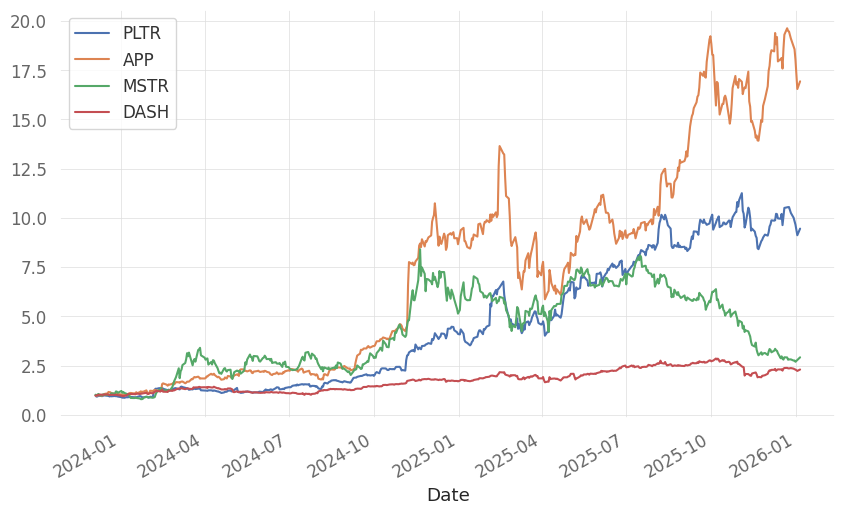

In [28]:
(data[["PLTR", "APP", "MSTR", "DASH"]].pct_change()+1).cumprod().plot()

In [29]:
type(results.momentum)

pandas.core.frame.DataFrame

In [30]:
top_five = results.momentum.iloc[-1].nlargest(5)

In [31]:
columns= top_five.index

<Axes: xlabel='Date'>

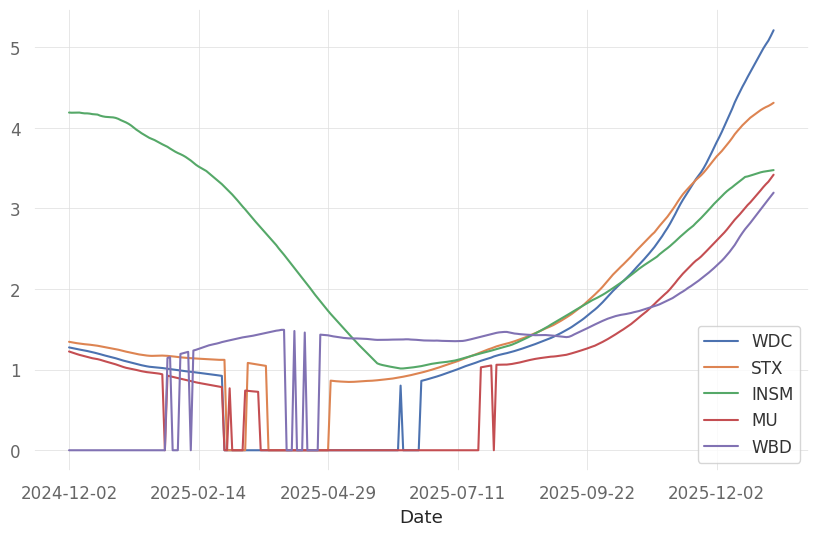

In [32]:
results.momentum[columns].plot()

In [33]:
slope = pd.DataFrame(np.gradient(results.momentum, axis= 0), results.momentum.index, results.momentum.columns)

<Axes: xlabel='Date'>

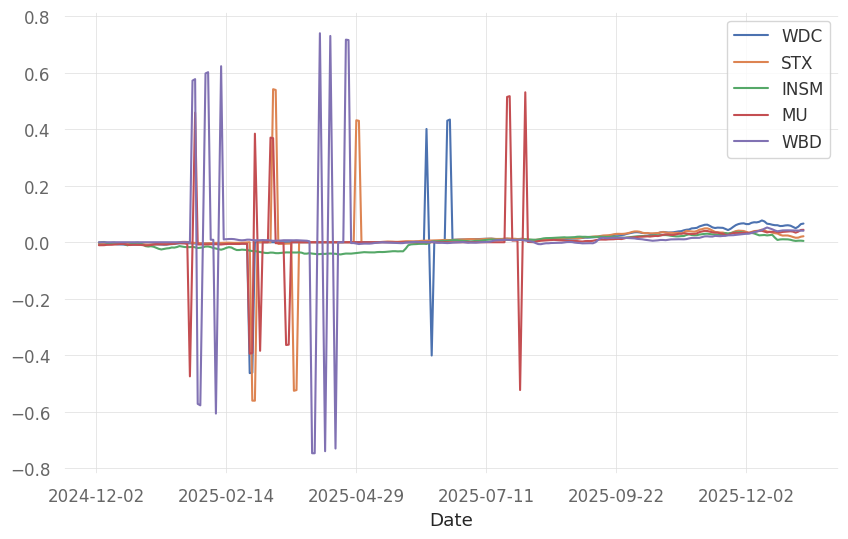

In [34]:
slope[columns].plot()

<Axes: xlabel='Date'>

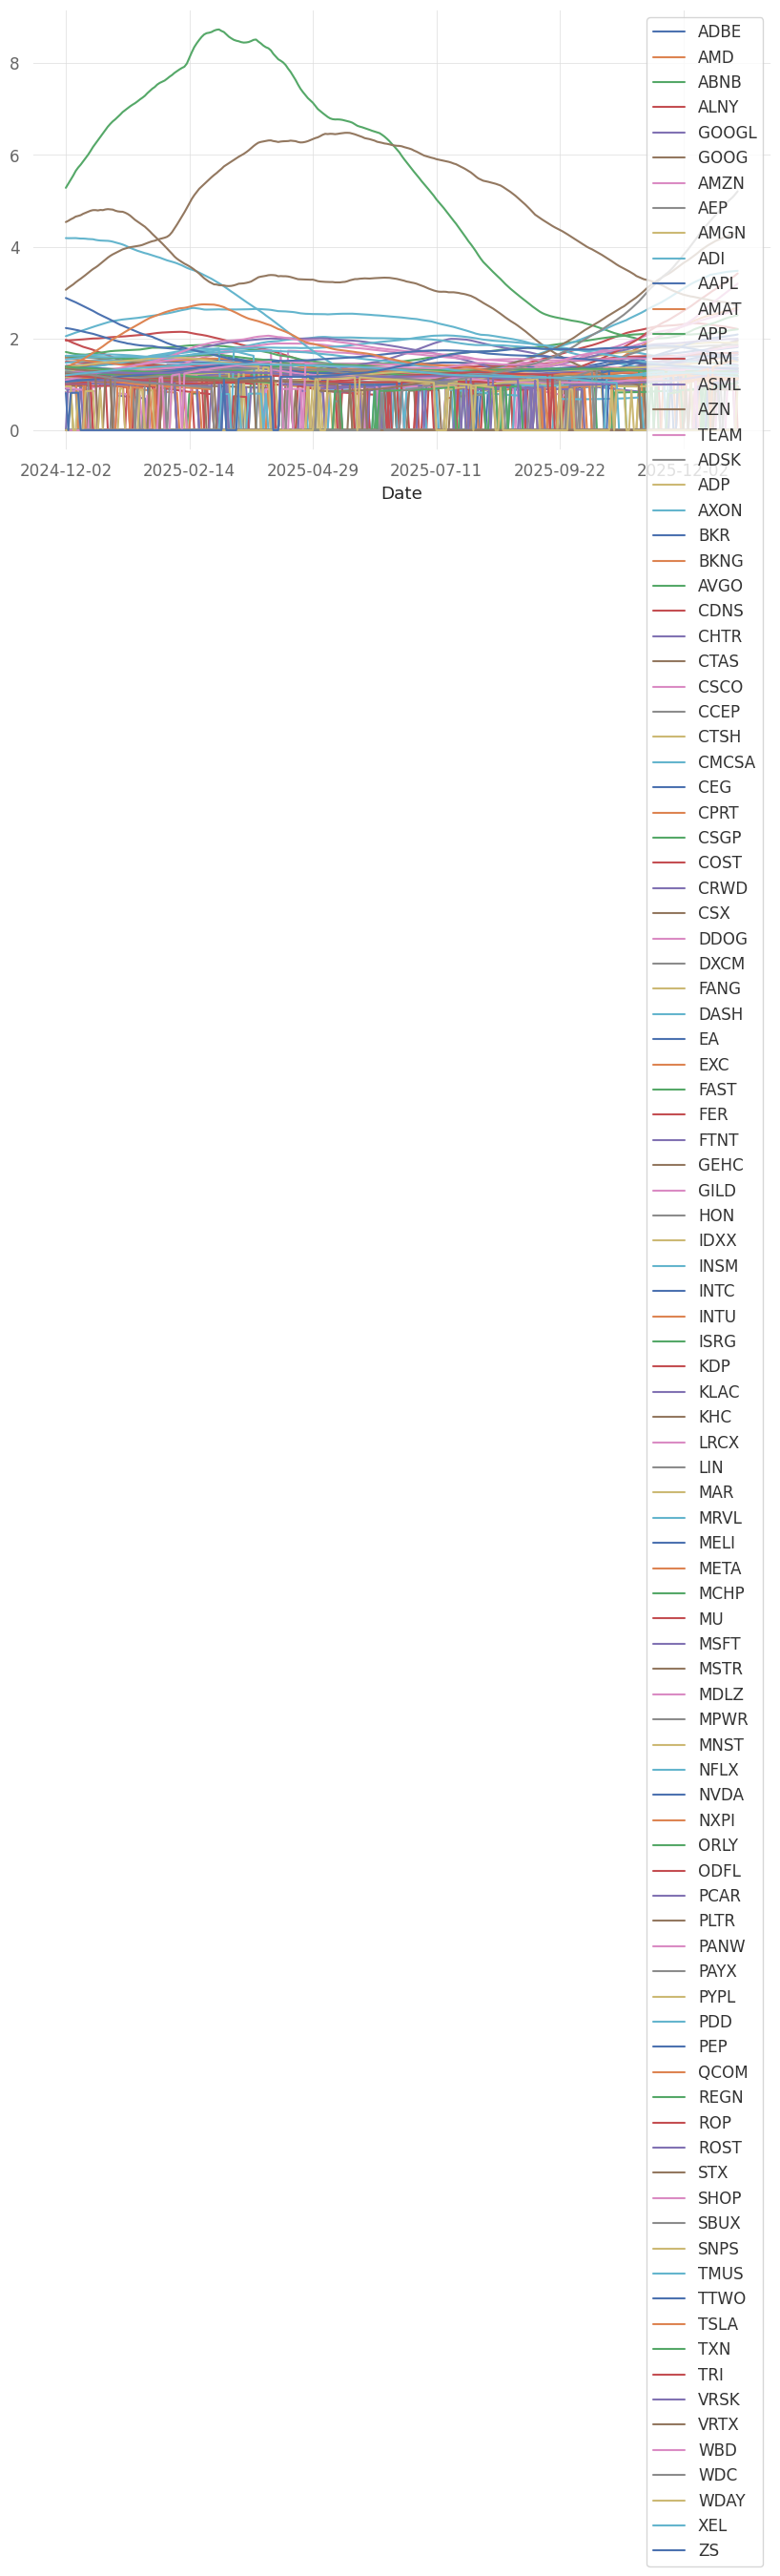

In [35]:
results.momentum.plot()